## PyMC GeoMod Sandstone Simplified

#### Importing stuff

In [4]:
%matplotlib inline
from IPython.core.display import Image

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import shutil
#import geobayes_simple as gs
from itertools import chain
import pymc as pm # PyMC 2
from pymc.Matplot import plot
from pymc import graph as gr
import pandas as pn
import numpy as np
#import daft
from IPython.core.pylabtools import figsize
figsize(12.5, 10)

In [5]:
# as we have our model and pygeomod in different paths, let's change the pygeomod path to the default path.
sys.path.append("C:\Users\Miguel\workspace\pygeomod\pygeomod")
#sys.path.append(r'/home/jni/git/tmp/pygeomod_tmp')
import geogrid
import geomodeller_xml_obj as gxml
reload(gxml)
reload(geogrid)

<module 'geogrid' from 'C:\Users\Miguel\workspace\pygeomod\pygeomod\geogrid.pyc'>

In [6]:
sandstone0 = r'..\Geomodeller\Sandstone_small\Sandstone_small.xml'
sandstone2 = r'..\Geomodeller\Sandstone_extremely_simpified\Sandstone_extremely_simpified.xml'
sandstone3 = r'..\Geomodeller\Sandstone_ASEG\Sandstone_ASEG.xml'
sandstone4 = r'C:\Users\Miguel\workspace\geobayes\paper_sandstone\models\Sandstone_Ruth.xml'
sandstone = r'C:\Users\Miguel\workspace\geobayes\paper_sandstone\models\SanstoneSimple\SanstoneSimple.xml'

In [7]:
try:
    shutil.copytree(r'C:/Users/Miguel/workspace/geobayes/paper_sandstone/models/SanstoneSimple/', 'Temp_Sandstone/')
except WindowsError:
    print "The folder is already created"

The folder is already created


#### Create the pygeomod model importing the GeoModeller model (last time I used model promised...)

Info about this step: pygeomod notebooks.

In [8]:
sandstone = 'Temp_Sandstone/SanstoneSimple.xml'
print sandstone 

Temp_Sandstone/SanstoneSimple.xml


In [9]:
reload(geogrid)
G1 = geogrid.GeoGrid()

# Using G1, we can read the dimensions of our Murci geomodel
G1.get_dimensions_from_geomodeller_xml_project(sandstone)

G1.set_dimensions(dim=(696094,746777,6866608,6920075,-9272,1000))

nx = 80
ny = 80
nz = 80

print "number of voxels", nx*ny*nz

G1.define_regular_grid(nx,ny,nz)

G1.update_from_geomodeller_project(sandstone)

number of voxels 512000


In [77]:
G1.grid

array([[[ 1.,  1.,  1., ...,  0.,  0.,  0.],
        [ 1.,  1.,  1., ...,  0.,  0.,  0.],
        [ 1.,  1.,  1., ...,  0.,  0.,  0.],
        ..., 
        [ 1.,  1.,  1., ...,  0.,  0.,  0.],
        [ 1.,  1.,  1., ...,  0.,  0.,  0.],
        [ 1.,  1.,  1., ...,  0.,  0.,  0.]],

       [[ 1.,  1.,  1., ...,  0.,  0.,  0.],
        [ 1.,  1.,  1., ...,  0.,  0.,  0.],
        [ 1.,  1.,  1., ...,  0.,  0.,  0.],
        ..., 
        [ 1.,  1.,  1., ...,  0.,  0.,  0.],
        [ 1.,  1.,  1., ...,  0.,  0.,  0.],
        [ 1.,  1.,  1., ...,  0.,  0.,  0.]],

       [[ 1.,  1.,  1., ...,  0.,  0.,  0.],
        [ 1.,  1.,  1., ...,  0.,  0.,  0.],
        [ 1.,  1.,  1., ...,  0.,  0.,  0.],
        ..., 
        [ 1.,  1.,  1., ...,  0.,  0.,  0.],
        [ 1.,  1.,  1., ...,  0.,  0.,  0.],
        [ 1.,  1.,  1., ...,  0.,  0.,  0.]],

       ..., 
       [[ 5.,  5.,  5., ...,  0.,  0.,  0.],
        [ 5.,  5.,  5., ...,  0.,  0.,  0.],
        [ 5.,  5.,  5., ...,  0.,  0., 

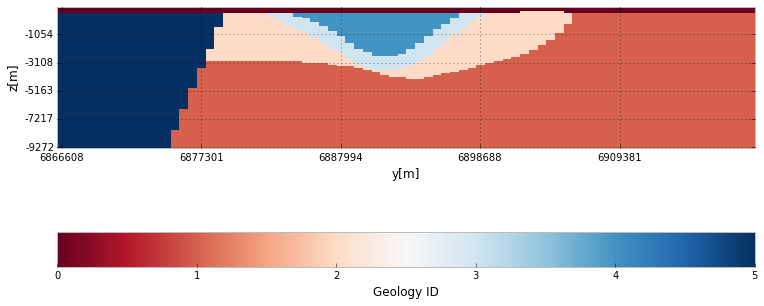

In [95]:
reload(geogrid)

G1.plot_section('x',cell_pos=40,colorbar = True,  cmap='RdBu', figsize=(12.5,10),interpolation= 'nearest' ,ve = 1, contour =False,geomod_coord= True)

### Creating the Bayesian Model of the input data!
#### First: Importing the uncertainty data from geolgical observations


In [11]:
data = pn.read_excel("C:\Users\Miguel\workspace\geobayes\paper_sandstone\models\Uncertainties.xlsx")                    
#print data[:,[0,3,6,7]]
data_ar = data.values[:,[0,3,6,7]]

np.asarray(data_ar[data_ar[:,1] == "depth"][:,[0,2,3]])


array([[u'SM_Seis_C', 5680.0, 500.0],
       [u'SM_Seis_E', 3050.0, 500.0],
       [u'SM_Sand_C', 5010.0, 100.0],
       [u'SM_Atley_1', 4550.0, 100.0],
       [u'SM_Atley_2', 3600.0, 100.0],
       [u'SM_Atley_3', 6000.0, 100.0],
       [u'SM_Atley_4', 3200.0, 100.0],
       [u'SM_Atley_5', 5600.0, 100.0],
       [u'BIF_Atley_2', 1800.0, 100.0],
       [u'BIF_Atley_3', 3900.0, 100.0],
       [u'BIF_Atley_4', 500.0, 100.0],
       [u'BIF_Atley_5', 1800.0, 100.0]], dtype=object)

## Creating out PyMC model our of this


In the first try we are gonna take the surface points as real values since in any case they will have less uncertainty.

In [52]:
a = np.array([7,5,6,4,6,7,2])
b = [6,2,5]
print np.amin(a)



2


In [98]:
#==============================
# Stochastics: Our input data
#============================
data_depth = np.asarray(data_ar[data_ar[:,1] == "depth"][:,[0, 2,3]])
contact_points_mc = []
for i in range(len(data_depth)):
    contact_points_mc = np.append(contact_points_mc, pm.Normal(str(data_depth[i,0]), data_depth[i,1], 1./np.square(data_depth[i,2])))


data_azimuth = np.asarray(data_ar[data_ar[:,1] == "azimuth"][:,[0, 2,3]])
azimuths_mc = []    
for i in range(len(data_azimuth)):
    azimuths_mc = np.append(azimuths_mc, pm.Normal(str(data_azimuth[i,0]), data_azimuth[i,1], 1./np.square(data_azimuth[i,2])))   

data_dip = np.asarray(data_ar[data_ar[:,1] == "dip"][:,[0, 2,3]])
dips_mc = []
for i in range(len(data_dip)):
    dips_mc = np.append(dips_mc, pm.Normal(str(data_dip[i,0]), data_dip[i,1], 1./np.square(data_dip[i,2])))  

    
#===============================
# First Constrains: Input data
#=============================
@pm.deterministic
def SM_Atley(contact_points_SM_Atley = contact_points_mc):
    SM_Atley = contact_points_mc[[int(np.argwhere(data_depth[:,0]=="SM_Atley_2")),int(np.argwhere(data_depth[:,0]=="SM_Atley_3")),
                              int(np.argwhere(data_depth[:,0]=="SM_Atley_4")),int(np.argwhere(data_depth[:,0]=="SM_Atley_5"))]]
    return SM_Atley
@pm.deterministic
def BIF_Atley(contact_points_BIF_Atley = contact_points_mc):
    BIF_Atley = contact_points_mc[[int(np.argwhere(data_depth[:,0]=="BIF_Atley_2")),int(np.argwhere(data_depth[:,0]=="BIF_Atley_3")),
                                  int(np.argwhere(data_depth[:,0]=="BIF_Atley_4")),int(np.argwhere(data_depth[:,0]=="BIF_Atley_5"))]]
    return BIF_Atley


@pm.potential
def order_layers(SM_Atley = SM_Atley, BIF_Atley = BIF_Atley):
    Atley_dif_1 = SM_Atley - BIF_Atley
    if np.amin(Atley_dif_1) < 500:
        return -1
    if np.amin(Atley_dif_1) < 0:
        return -2
    return 0
   
# ===============================================================================
# Generation of model
# ===============================================================================
@pm.deterministic
def model(contact_points_val_mc = contact_points_mc, azimuths_val = azimuths_mc , dips_val = dips_mc):
# IMPORTANT NOTE: To be sure that the point we want to change fit with the Observation ID, I use the distribution name that
# in this case is in contact_points(parent values). Children values (contact_points_val) only have the number itself
    
    #print "contact_points_mc", contact_points_mc, contact_points_mc[0].value
    #print "caontact points val_mc", contact_points_val_mc[0]
   
  
    # Create the array we will use to modify the xml. We have to check the order of the formations
    
    
        #==================================================
        # Loading old model
        #==============================================
    # Load the xml to be modify
    org_xml = 'Temp_Sandstone/SanstoneSimple.xml'
    
    #Create the instance to modify the xml
        # Loading stuff
    reload(gxml)
    gmod_obj = gxml.GeomodellerClass()
    gmod_obj.load_geomodeller_file(org_xml)

    
        #============================================
        # Modifing the model
        #===========================================
    gmod_obj.change_formation_values_PyMC(contact_points_mc = contact_points_mc,
                                         azimuths_mc = azimuths_mc,
                                         dips_mc = dips_mc)
    
 
    
        #==============================================
        # wtiting new model
        #============================================

    # Write the new xml
    gmod_obj.write_xml("Temp_Sandstone/new.xml")
       
    # Read the new xml
    new_xml = 'Temp_Sandstone/new.xml'
    G1 = geogrid.GeoGrid()
    
    # Getting dimensions and definning grid
    G1.get_dimensions_from_geomodeller_xml_project(new_xml)
    G1.set_dimensions(dim=(696094,746777,6866608,6920075,-9272,1000))
    
    # Resolution!
    nx = 80
    ny = 80
    nz = 80
    G1.define_regular_grid(nx,ny,nz)
    
    # Updating project
    G1.update_from_geomodeller_project(new_xml)
    
    return G1
 


#================================
# Second Constrains: Interpolation
#===============================

@pm.potential
def test_1(G_grid = G1.grid):
    print G_grid
    return 0



#=================================
# Inversion
#=================================




#===========================================================00
#===========================================================
#CREATING THE MODEL
#==========================================================
#=========================================================

# Chaining the arrays
parameters = list(chain(contact_points_mc,dips_mc,azimuths_mc))

# Appending the rest
parameters.append(model)
parameters.append(BIF_Atley)
parameters.append(SM_Atley)
parameters.append(order_layers)

#print np.shape(parameters), parameters

pymc_model = pm.Model( parameters)

[[[ 1.  1.  1. ...,  0.  0.  0.]
  [ 1.  1.  1. ...,  0.  0.  0.]
  [ 1.  1.  1. ...,  0.  0.  0.]
  ..., 
  [ 1.  1.  1. ...,  0.  0.  0.]
  [ 1.  1.  1. ...,  0.  0.  0.]
  [ 1.  1.  1. ...,  0.  0.  0.]]

 [[ 1.  1.  1. ...,  0.  0.  0.]
  [ 1.  1.  1. ...,  0.  0.  0.]
  [ 1.  1.  1. ...,  0.  0.  0.]
  ..., 
  [ 1.  1.  1. ...,  0.  0.  0.]
  [ 1.  1.  1. ...,  0.  0.  0.]
  [ 1.  1.  1. ...,  0.  0.  0.]]

 [[ 1.  1.  1. ...,  0.  0.  0.]
  [ 1.  1.  1. ...,  0.  0.  0.]
  [ 1.  1.  1. ...,  0.  0.  0.]
  ..., 
  [ 1.  1.  1. ...,  0.  0.  0.]
  [ 1.  1.  1. ...,  0.  0.  0.]
  [ 1.  1.  1. ...,  0.  0.  0.]]

 ..., 
 [[ 5.  5.  5. ...,  0.  0.  0.]
  [ 5.  5.  5. ...,  0.  0.  0.]
  [ 5.  5.  5. ...,  0.  0.  0.]
  ..., 
  [ 1.  1.  1. ...,  0.  0.  0.]
  [ 1.  1.  1. ...,  0.  0.  0.]
  [ 1.  1.  1. ...,  0.  0.  0.]]

 [[ 5.  5.  5. ...,  0.  0.  0.]
  [ 5.  5.  5. ...,  0.  0.  0.]
  [ 5.  5.  5. ...,  0.  0.  0.]
  ..., 
  [ 1.  1.  1. ...,  0.  0.  0.]
  [ 1.  1.  1. ...,  

In [70]:
M = pm.MCMC(pymc_model)
M.sample(iter=10)

 [------------------110%-------------------] 11 of 10 complete in 182.2 sec

In [71]:
n_samples = 9

section_samples, section_samples_all = M.trace('model')[-n_samples:], M.trace('model')[:]

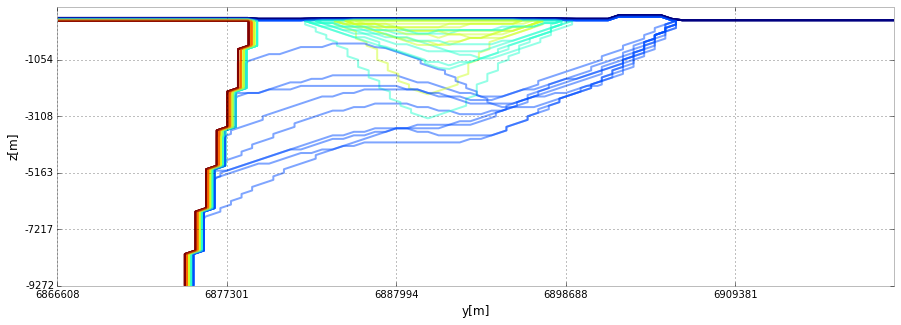

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))


for i in section_samples:
    i.plot_section('x',cell_pos=40,colorbar = True, ax = ax, alpha = 0.5, figsize=(6,6),interpolation= 'nearest' ,ve = 1, geomod_coord= True, contour = True)
    
    


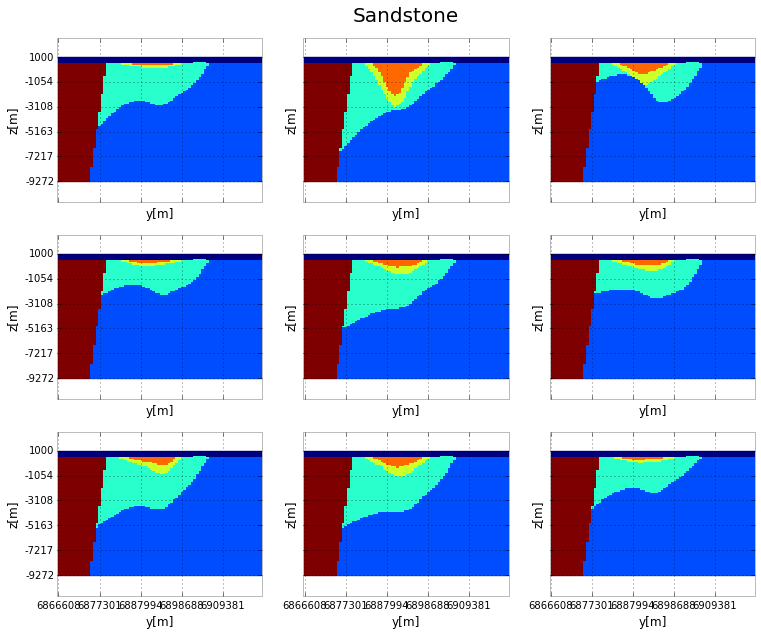

In [93]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True)

plt.text(0.5, 1.1, "Sandstone",
     horizontalalignment='center',
        fontsize=20,
        transform = axs[0,1].transAxes)
#plt.subplots_adjust(top=2.15)
#axs[0,1].set_title("Posterior Faults: Non-Constrains", fontsize=20)

for i, g  in enumerate(section_samples):
    g.plot_section('x',cell_pos=40,colorbar = True,  ax = axs[i- 3*(i/3),i/3], alpha = 1, figsize=(6,6),interpolation= 'nearest' ,ve = 3, geomod_coord= True, contour = False)    

Plotting SM_Sand_Ori_C_a
Plotting SM_Atley_Ori_C_d
Plotting SM_Sand_C
Plotting BIF_Atley_4
Plotting BIF_Atley_5
Plotting SM_Sand_Ori_W_a
Plotting SM_Atley_1
Plotting SM_Atley_Ori_E_a
Plotting BIF_Atley_2
Plotting SM_Sand_Ori_C_d
Plotting SM_Atley_Ori_W_d
Plotting BIF_Atley_Ori_E_d
Plotting SM_Atley_2
Plotting SM_Atley_4
Plotting SM_Sand_Ori_E_d
Plotting SM_Seis_Ori_C_d
Plotting SM_Seis_C
Plotting SM_Seis_Ori_E_d
Plotting BIF_Atley_Ori_E_a
Plotting SM_Seis_Ori_W_d
Plotting BIF_Atley_Ori_W_a
Plotting BIF_Atley_3
Plotting SM_Seis_E
Plotting SM_Seis_Ori_C_a
Plotting BIF_Atley_Ori_W_d
Plotting SM_Atley_Ori_W_a
Plotting SM_Atley_3
Plotting SM_Seis_Ori_W_a
Plotting SM_Atley_Ori_C_a
Plotting SM_Seis_Ori_E_a
Plotting SM_Atley_Ori_E_d
Plotting SM_Sand_Ori_E_a
Plotting SM_Sand_Ori_W_d
Plotting SM_Atley_5


C:\Users\Miguel\Anaconda\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


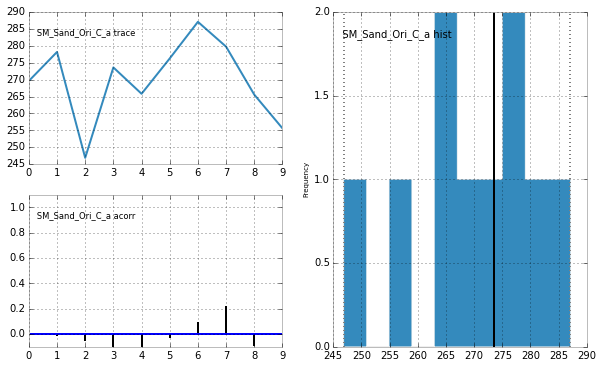

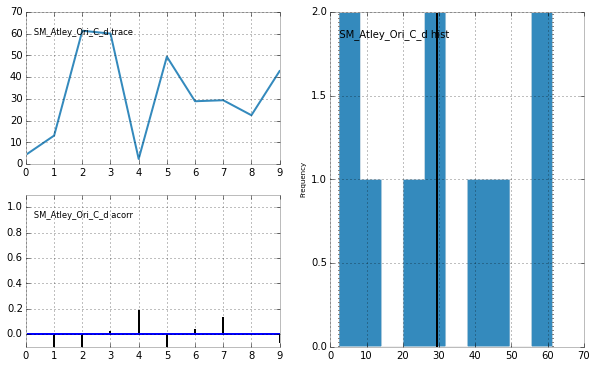

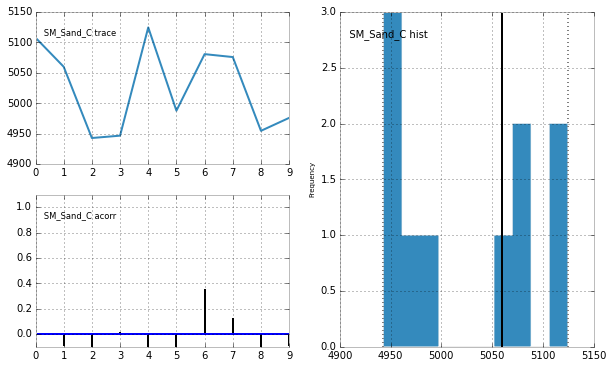

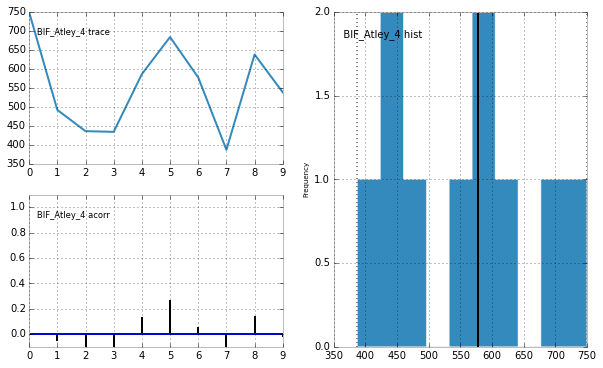

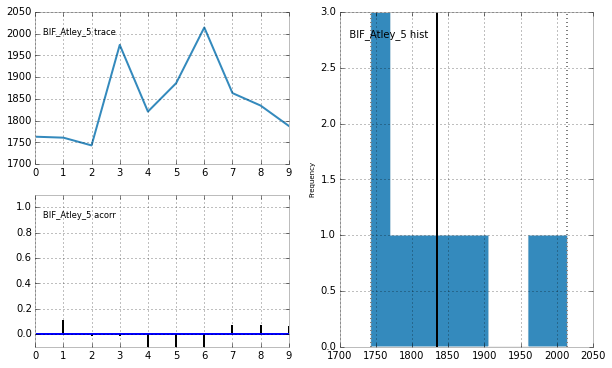

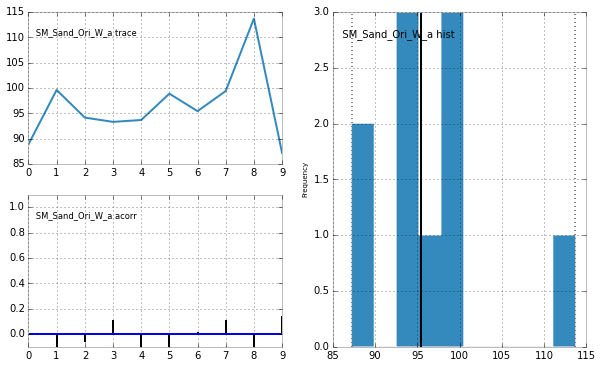

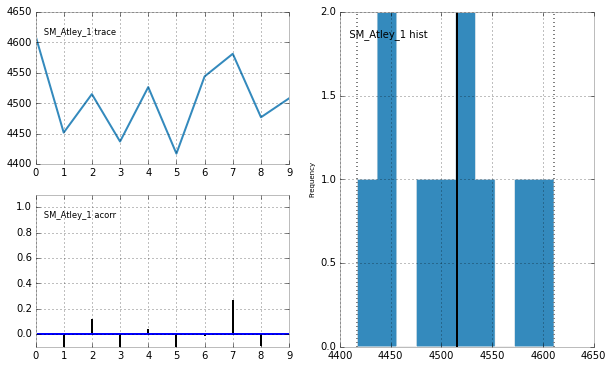

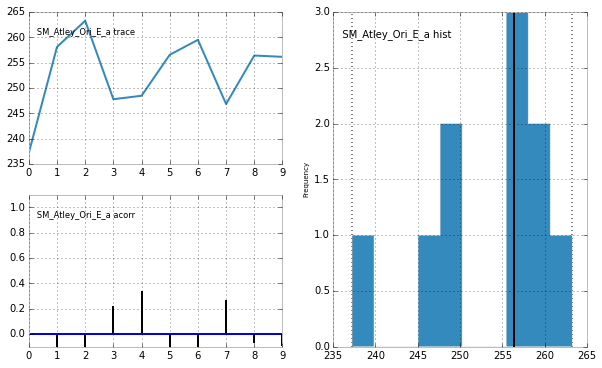

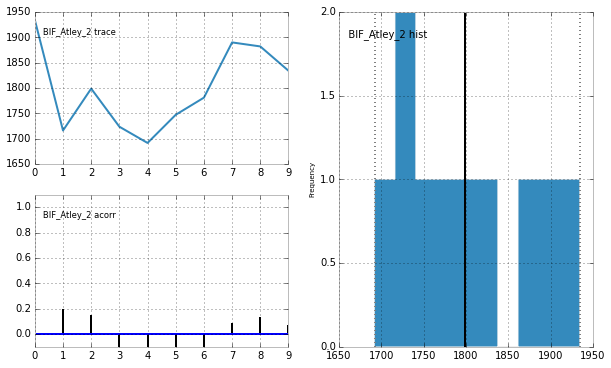

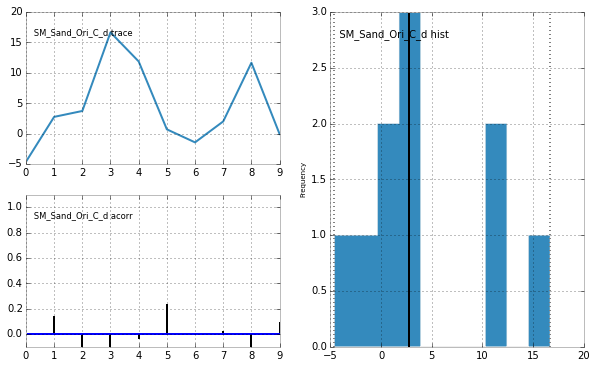

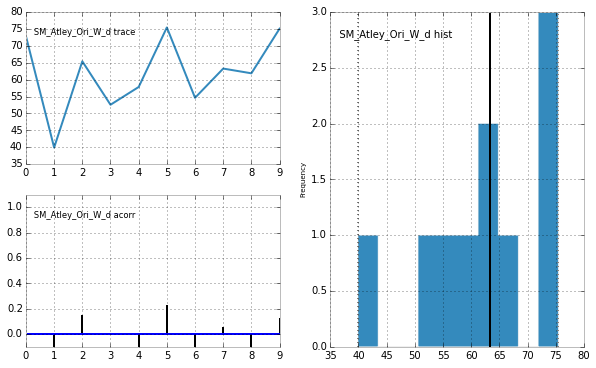

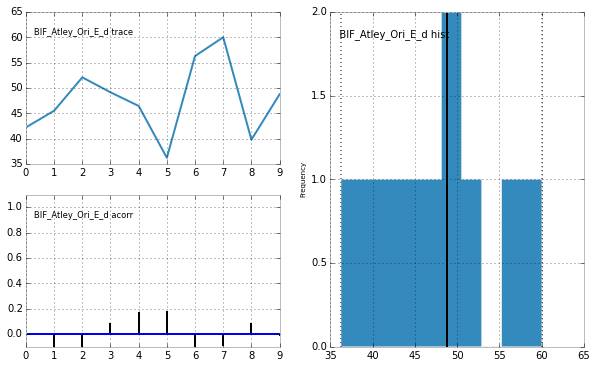

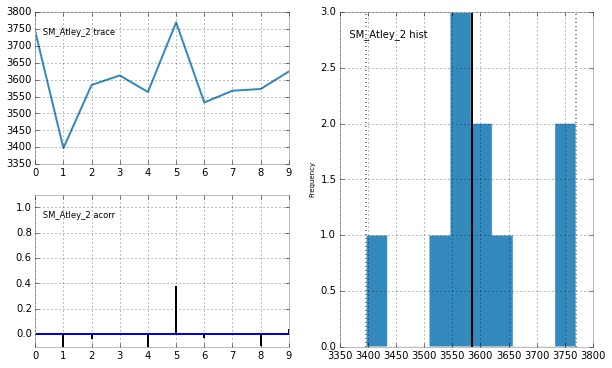

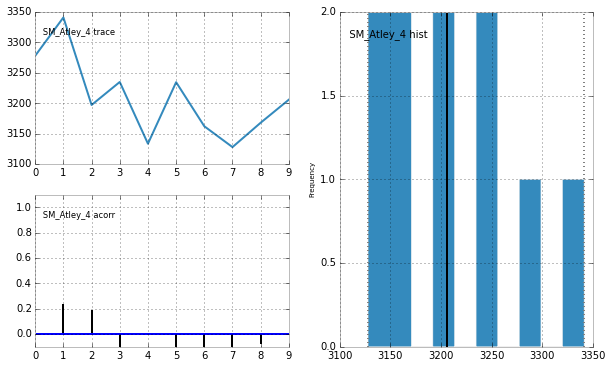

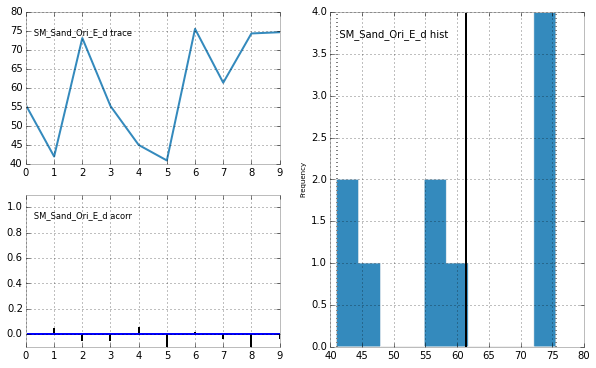

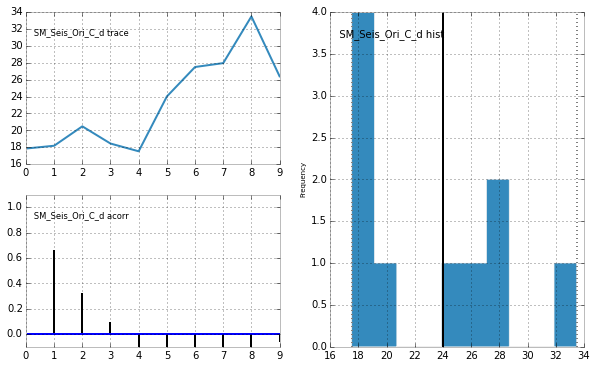

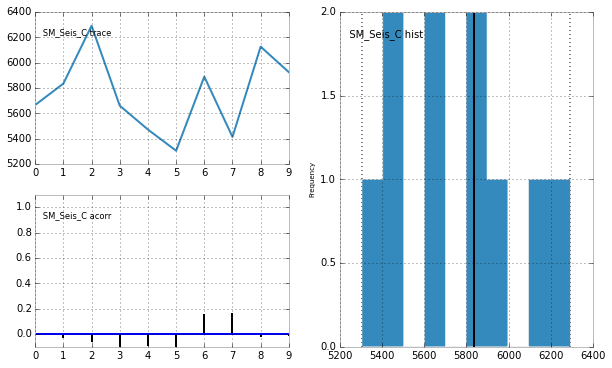

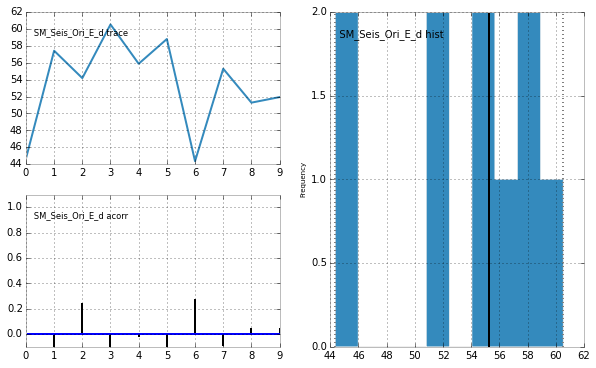

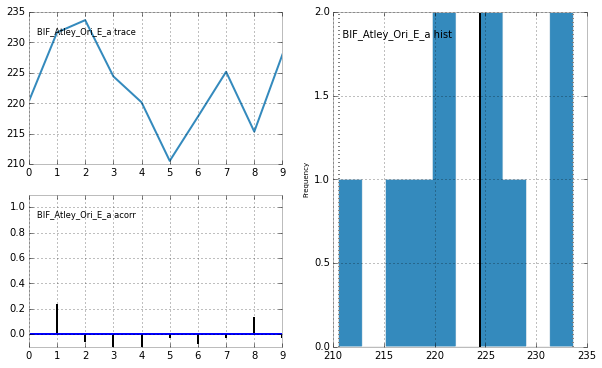

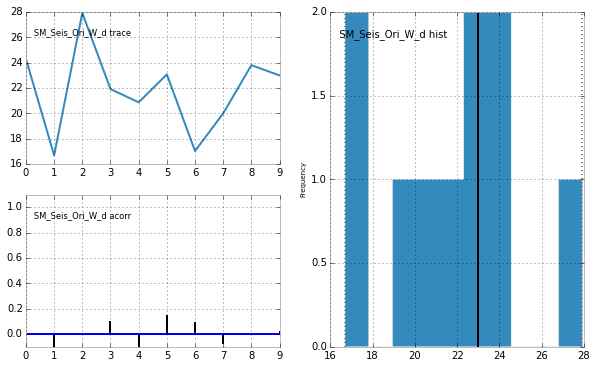

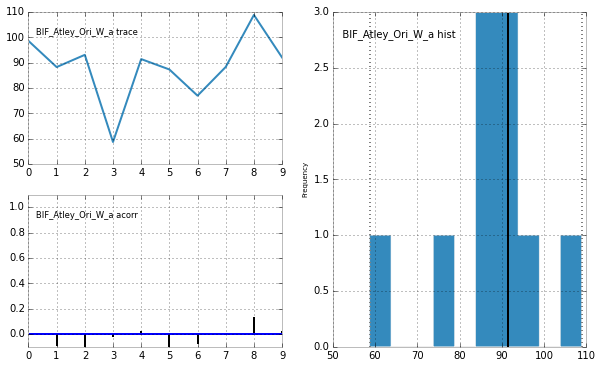

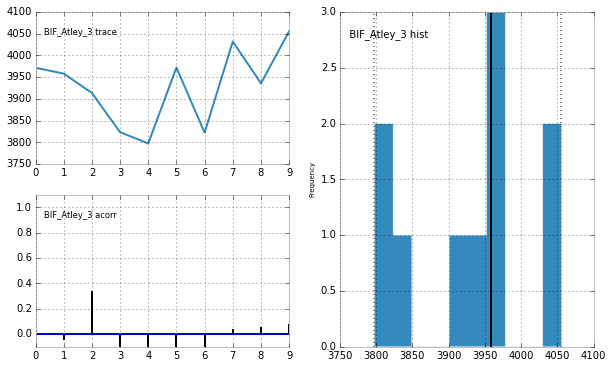

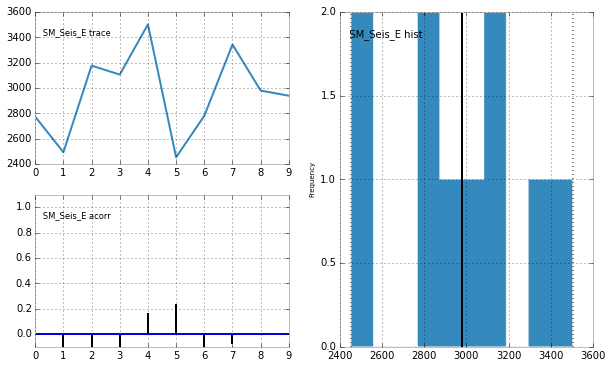

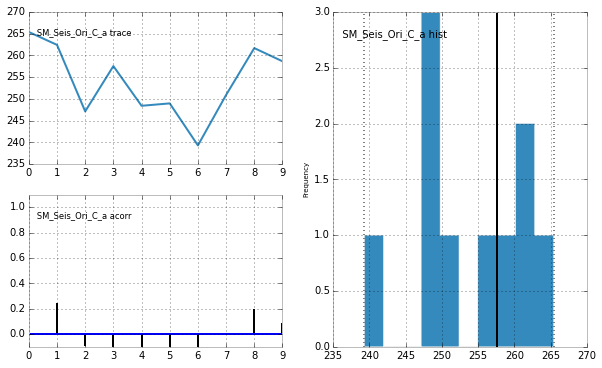

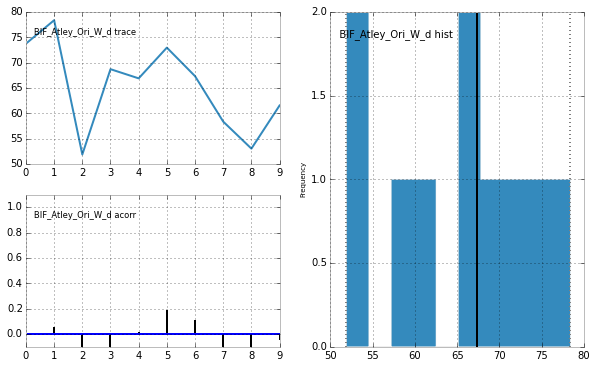

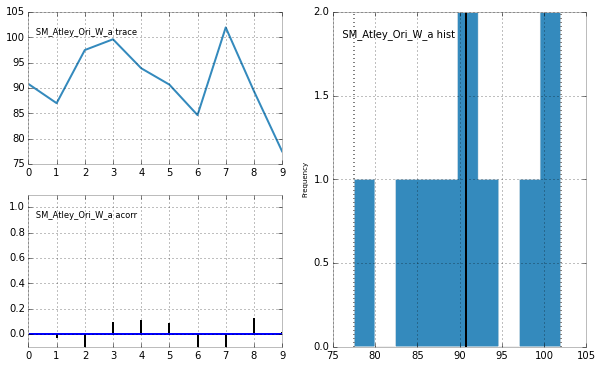

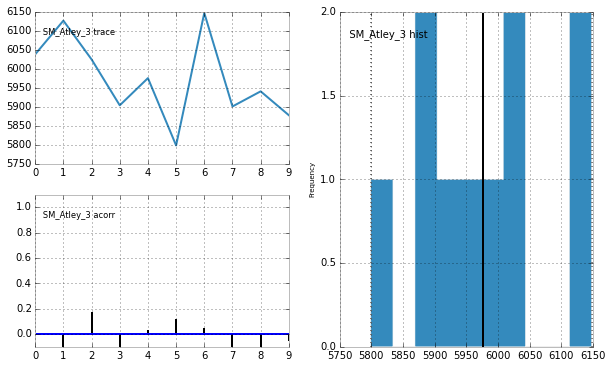

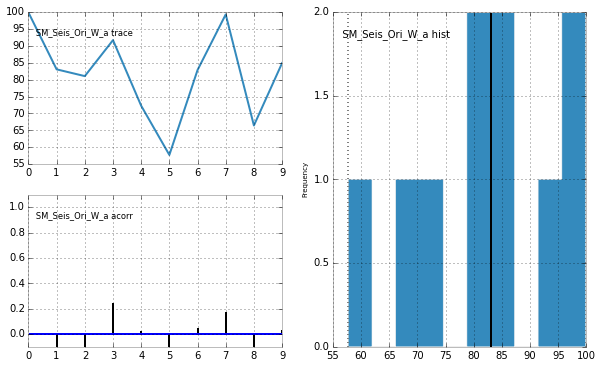

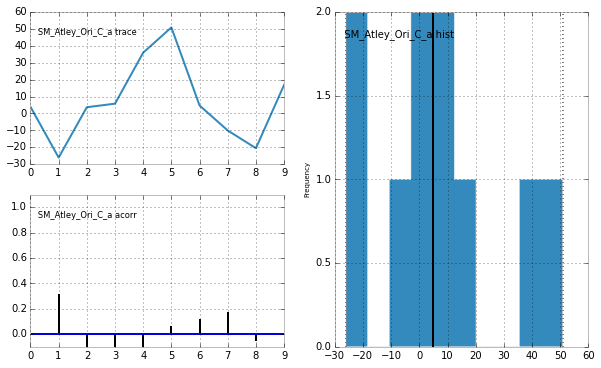

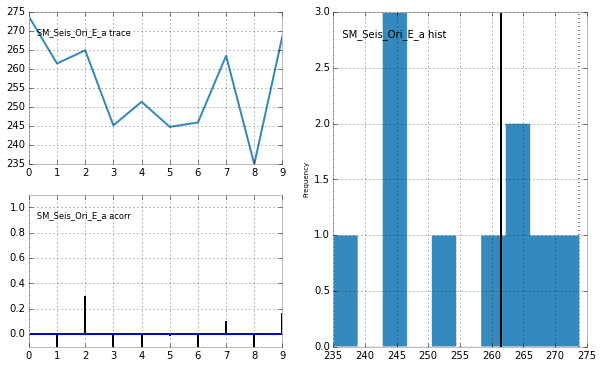

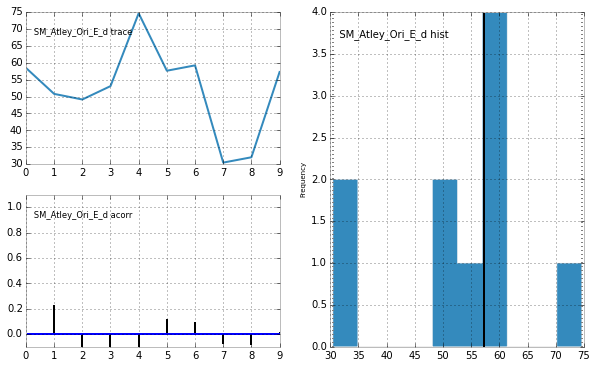

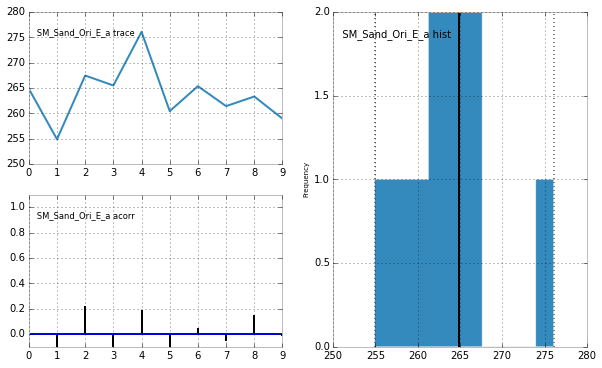

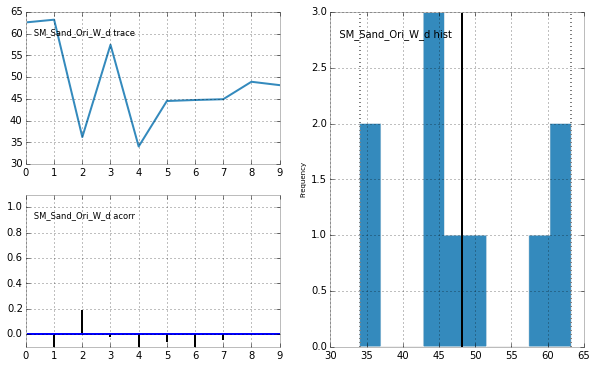

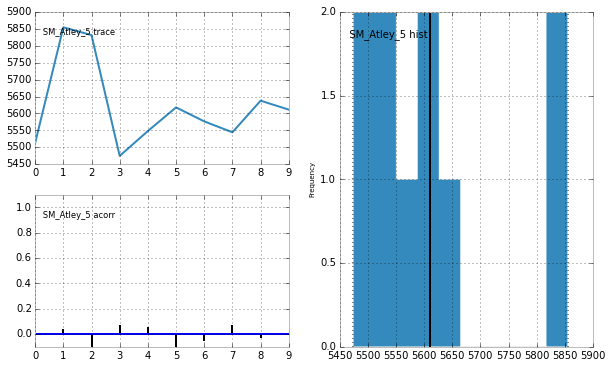

In [53]:
plot(M)


In [60]:
a = gr.dag(pymc_model)
a.write_png("Sandstone.png")

True

In [62]:
gr.dag?

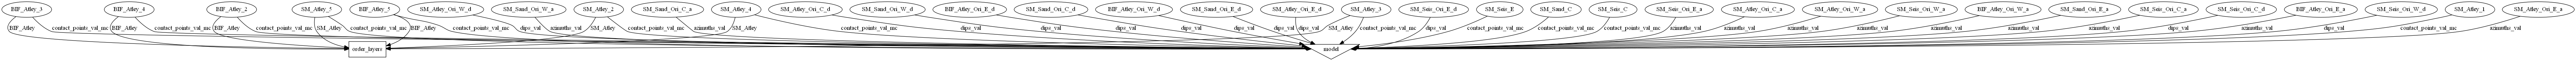

In [61]:
Image("Sandstone.png")

## Visualization of the parameters that change in every iteration

### Info values in original xml

In [34]:
reload(gxml)
gmod_obj = gxml.GeomodellerClass()
gmod_obj.load_geomodeller_file(sandstone)

gmod_obj.change_formation_values_PyMC(info = True)




Seismic 

Elements and their ID 

<Element '{http://www.geomodeller.com/geo}Interface' at 0x1a47f8d0> SM_Seis_E
<Element '{http://www.geomodeller.com/geo}Interface' at 0x1a47f9e8> SM_Seis_C
<Element '{http://www.geomodeller.com/geo}Foliation' at 0x1a47fb38> SM_Seis_Ori_C
<Element '{http://www.geomodeller.com/geo}Foliation' at 0x1a47fcc0> SM_Seis_Ori_E
<Element '{http://www.geomodeller.com/geo}Foliation' at 0x1a47fe48> SM_Seis_Ori_W

Dictionaries:
  {'SM_Seis_C': <Element '{http://www.geomodeller.com/geo}Interface' at 0x1a47f9e8>, 'SM_Seis_E': <Element '{http://www.geomodeller.com/geo}Interface' at 0x1a47f8d0>} 
{'SM_Seis_Ori_C_d': <Element '{http://www.geomodeller.com/geo}Foliation' at 0x1a47fb38>, 'SM_Seis_Ori_C_a': <Element '{http://www.geomodeller.com/geo}Foliation' at 0x1a47fb38>, 'SM_Seis_Ori_E_d': <Element '{http://www.geomodeller.com/geo}Foliation' at 0x1a47fcc0>, 'SM_Seis_Ori_W_a': <Element '{http://www.geomodeller.com/geo}Foliation' at 0x1a47fe48>, 'SM_Seis_Ori_E_a': <Eleme

### Info values in changed xml

In [33]:
reload(gxml)
gmod_obj = gxml.GeomodellerClass()
gmod_obj.load_geomodeller_file( 'Temp_Sandstone/new.xml')
gmod_obj.change_formation_values_PyMC(info = True)




Seismic 

Elements and their ID 

<Element '{http://www.geomodeller.com/geo}Interface' at 0x1b777940> SM_Seis_E
<Element '{http://www.geomodeller.com/geo}Interface' at 0x1b777a20> SM_Seis_C
<Element '{http://www.geomodeller.com/geo}Foliation' at 0x1b777b38> SM_Seis_Ori_C
<Element '{http://www.geomodeller.com/geo}Foliation' at 0x1b777c88> SM_Seis_Ori_E
<Element '{http://www.geomodeller.com/geo}Foliation' at 0x1b777dd8> SM_Seis_Ori_W

Dictionaries:
  {'SM_Seis_C': <Element '{http://www.geomodeller.com/geo}Interface' at 0x1b777a20>, 'SM_Seis_E': <Element '{http://www.geomodeller.com/geo}Interface' at 0x1b777940>} 
{'SM_Seis_Ori_C_d': <Element '{http://www.geomodeller.com/geo}Foliation' at 0x1b777b38>, 'SM_Seis_Ori_C_a': <Element '{http://www.geomodeller.com/geo}Foliation' at 0x1b777b38>, 'SM_Seis_Ori_E_d': <Element '{http://www.geomodeller.com/geo}Foliation' at 0x1b777c88>, 'SM_Seis_Ori_W_a': <Element '{http://www.geomodeller.com/geo}Foliation' at 0x1b777dd8>, 'SM_Seis_Ori_E_a': <Eleme

In [53]:
# Section names:
section_names = gmod_obj.get_section_names()
print "section names",section_names, "\n" 

# Choose the section we want to use with Positon
sections = gmod_obj.get_sections()
print "Chosen section by position", sections, "\n"

# Create a dictionary so we can acces the section through the name
section_dict = gmod_obj.create_sections_dict()
print "Chosen section by entry", section_dict["Seismic"][1], "\n"



# Formation names
formation_names = gmod_obj.get_formation_names()
print "formation names", formation_names, "\n"

# Get the points of all formation for a given section: Position
#contact_points = gmod_obj.get_formation_point_data(sections) #to extract points you have to choose one of the sections
#print "Contact points on the chosen section", contact_points, "\n", type(contact_points)

## Get the points of all formation for a given section: Dictionary
contact_points = gmod_obj.get_formation_point_data(section_dict['Atley']) #to extract points you have to choose one of the sections
print "Contact points on the chosen section", contact_points, "\n", type(contact_points), np.shape(contact_points)

# Showing contact points
points = gmod_obj.get_point_coordinates(contact_points)
print "Points coordinates\n", points, np.shape(points), "\n"

# Foliations

foliations = gmod_obj.get_foliations(section_dict['Atley'])
print "foliations" , foliations,  "\n\n\n"
for i in range(len(foliations)): print "azimut:",gmod_obj.get_foliation_azimuth(foliations[i]), "dip",gmod_obj.get_foliation_dip(foliations[i]), "coordinates", gmod_obj.get_foliation_coordinates(foliations[i])  


section names ['Atley', 'NorthSandstone', 'Seismic', 'SurfaceTopography'] 

Chosen section by position [<Element '{http://www.geomodeller.com/geo}Section' at 0x36a64748>, <Element '{http://www.geomodeller.com/geo}Section' at 0x36a19ba8>, <Element '{http://www.geomodeller.com/geo}Section' at 0x2e598cc0>, <Element '{http://www.geomodeller.com/geo}Section' at 0x3262f1d0>] 

Chosen section by entry <Element '{http://www.geomodeller.com/geo}Structural2DData' at 0x2e598ef0> 

formation names ['EarlyGranite', 'Murchison', 'SimpleBIF', 'SimpleMafic', 'SimpleMafic2'] 

Contact points on the chosen section [<Element '{http://www.geomodeller.com/geo}Interface' at 0x36a64cf8>, <Element '{http://www.geomodeller.com/geo}Interface' at 0x36a64e10>, <Element '{http://www.geomodeller.com/geo}Interface' at 0x36a64f28>, <Element '{http://www.geomodeller.com/geo}Interface' at 0x36a73080>, <Element '{http://www.geomodeller.com/geo}Interface' at 0x36a73198>, <Element '{http://www.geomodeller.com/geo}Interfac